In [54]:
import pandas as pd
import numpy as np
from os.path import join
import matplotlib.pyplot as plt

In [55]:
from typing import Tuple

In [56]:
data_path = 'data'

In [57]:
data = pd.read_csv(join(data_path, 'clear_data.csv'), parse_dates=['Date_round'])
data.shape

(1436617, 22)

In [58]:
def get_inliers_mask_target(df: pd.DataFrame) -> np.ndarray:
       # p = df.groupby('RanksID')['Perf_1Y'].min()
       p = df.groupby('RanksID')['Perf_1Y'].max()
       badids = set(p[abs(p) > 3].index)
       return  np.array([el not in badids for el in df.RanksID])

In [59]:
mask = get_inliers_mask_target(data)
print(data[mask].shape[0]/data.shape[0])
data = data[mask]

0.8421931523850824


In [60]:
valid_columns = ['Date_round', 'RanksID', 'Perf_1Y', 'Country_of_Headquarters',
       'Price_To_Tangible_Book_Value_Per_Share',
       'C_Price_To_Tangible_Book_Value_Per_Share',
       'Price_To_Book_Value_Per_Share', 'C_Price_To_Book_Value_Per_Share',
       'Enterprise_Value_to_Sales', 'Price_To_Sales_Per_Share',
       'Company_Shares', 'MCap_group', 'Enterprise_Value', 'gicsSectorName',
       'gicsIndustryGroupName', 'gicsIndustryName', 'gicsSubIndustryName',
       'Free_Cash_Flow_net_of_Dividends_per_Share',
       'C_Price_to_FCF_net_of_Dividends_per_Share',
       'Enterprise_Value_to_EBITDA', 'Enterprise_Value_to_Operating_Cash_Flow',
       'Price_to_Cash_Flow_per_Share', 'P_to_E']

gics_names = ['gicsSectorName', 'gicsIndustryGroupName','gicsIndustryName','gicsSubIndustryName']

useless_columns = ['MCap_group']

util_columns = ['Date_round', 'RanksID', 'Perf_1Y']
cat_columns = gics_names + ['Country_of_Headquarters']
reg_columns = [el for el in valid_columns if el not in useless_columns + cat_columns + util_columns]

In [61]:
def get_inliers_borders(arr:np.ndarray, lq:float=0.025, rq:float=0.975) -> Tuple[float, float]:
       q1, q2 = np.quantile(arr,[lq,rq])
       iqr = q2 - q1
       lb = q1 - 1.5 * iqr
       ub = q2 + 1.5 * iqr

       return lb, ub

In [62]:
def get_inliers_mask(arr:np.ndarray, lq:float=0.025, rq:float=0.975) -> np.ndarray:
       lb, ub = get_inliers_borders(arr, lq, rq)

       return (lb < arr) & (arr < ub)

In [63]:
lq, rq = 0.1, 0.9

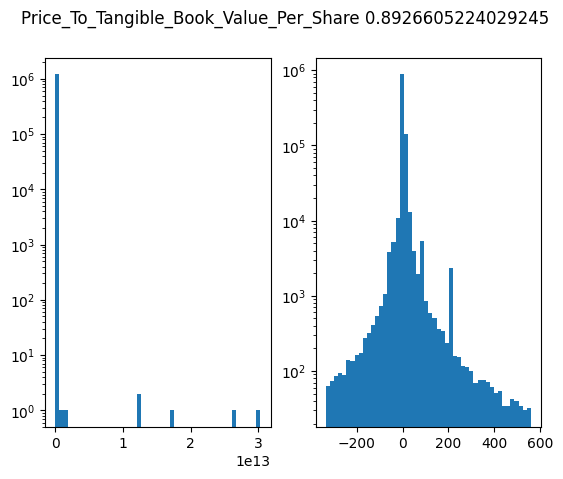

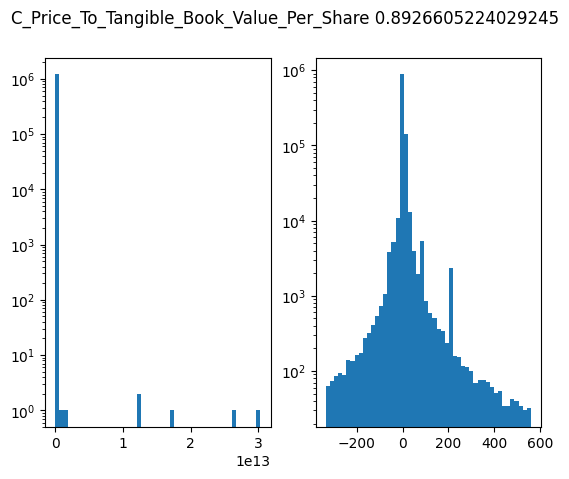

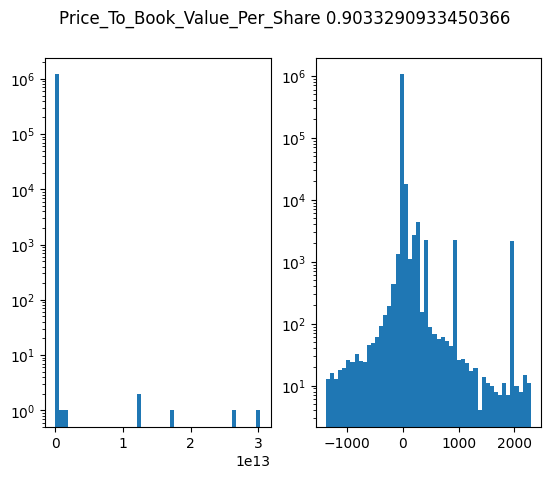

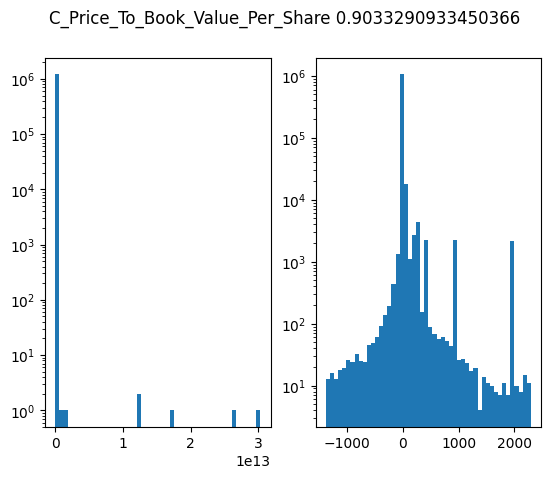

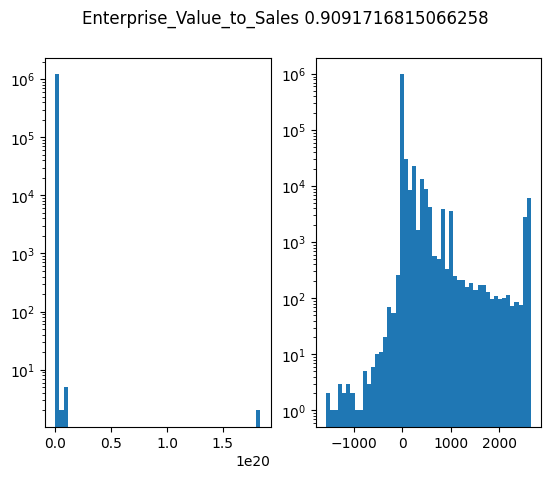

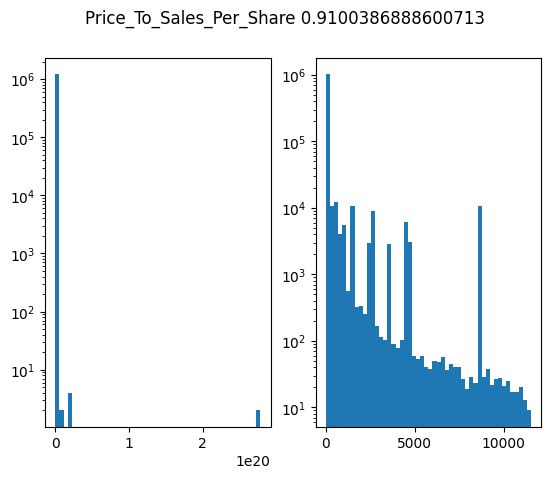

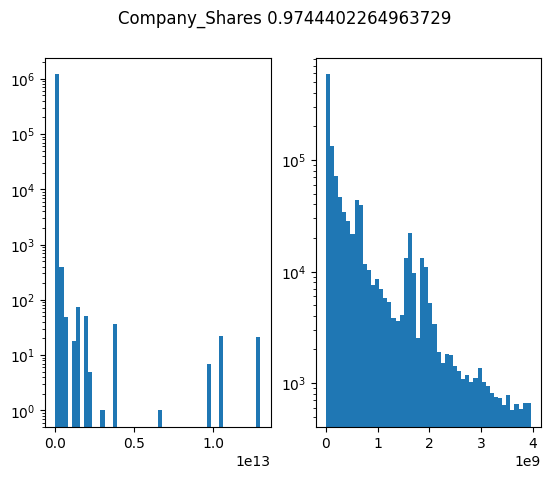

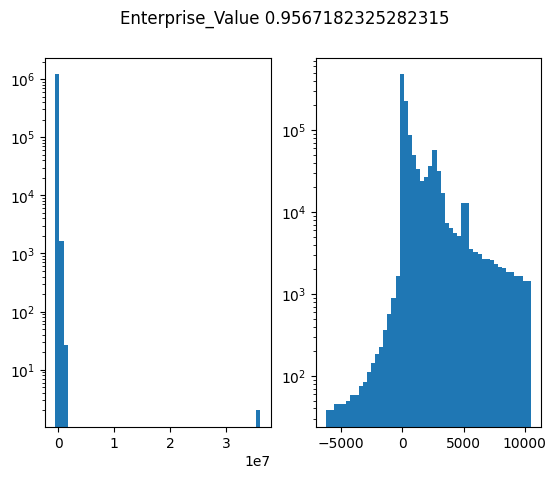

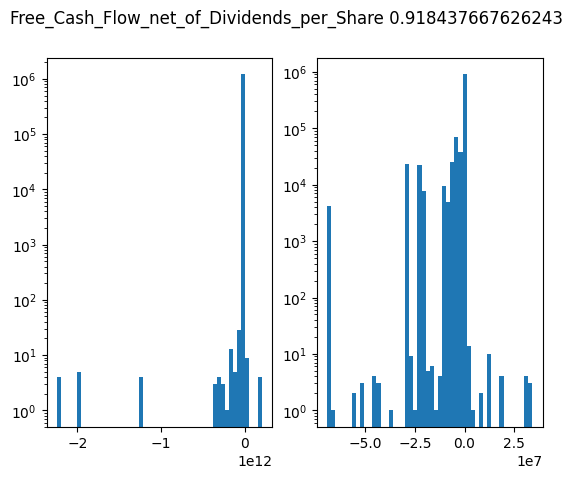

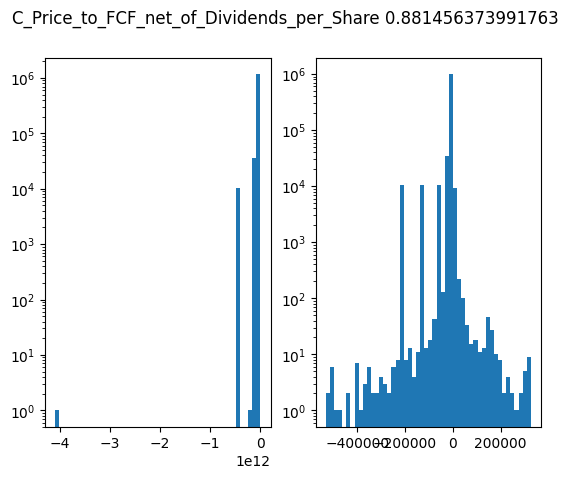

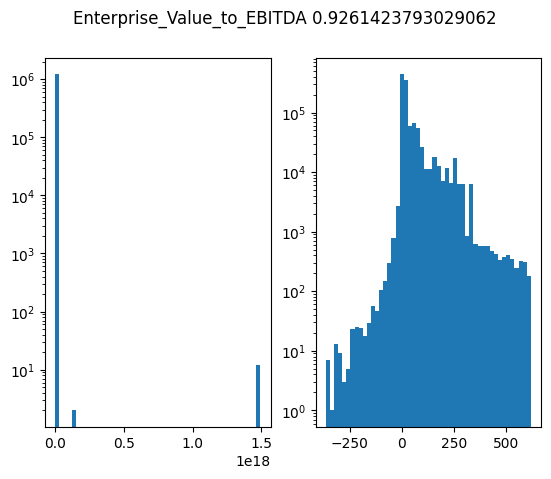

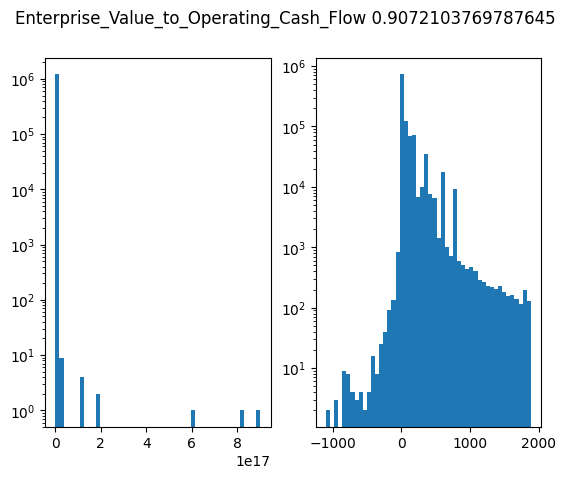

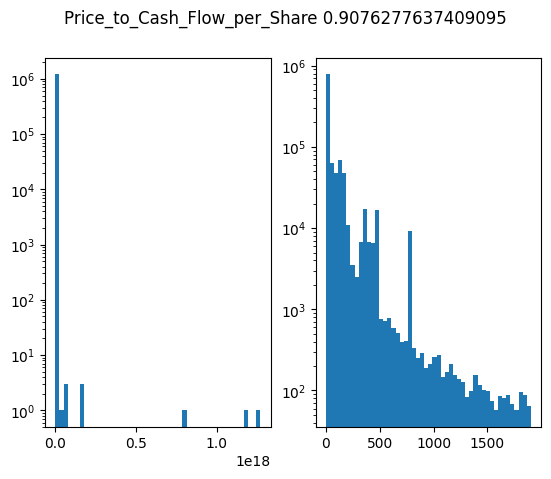

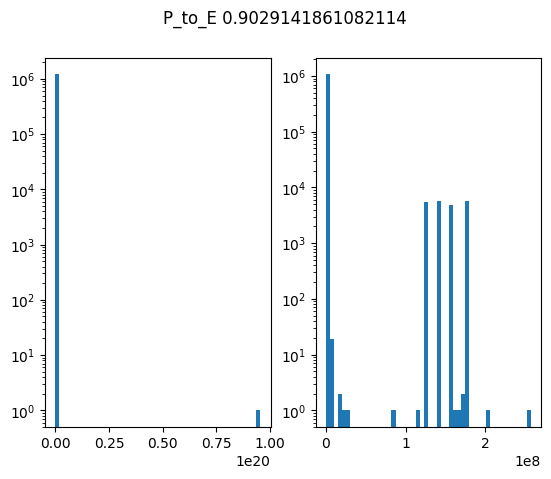

In [64]:
not_outlier_ratios = []
for fn in reg_columns:
       arr = data[fn].to_numpy()
       f_arr = arr[get_inliers_mask(arr,lq, rq)]
       fig, ax = plt.subplots(1, 2)
       ax[0].hist(arr, bins=50, log=True);
       ax[1].hist(f_arr, bins=50, log=True);
       not_outlier_ratio = f_arr.shape[0]/arr.shape[0]
       plt.suptitle(f'{fn} {not_outlier_ratio}')
       not_outlier_ratios.append((not_outlier_ratio, fn))

In [65]:
filter_names = [fn for ratio, fn in not_outlier_ratios if ratio > 0.8]

In [66]:
mask = np.ones(data.shape[0], dtype=bool)
for fn in filter_names:
       arr = data[fn].to_numpy()
       mask &= get_inliers_mask(arr,lq, rq)

In [67]:
data[mask].shape[0]/data.shape[0]

0.6461601657645327

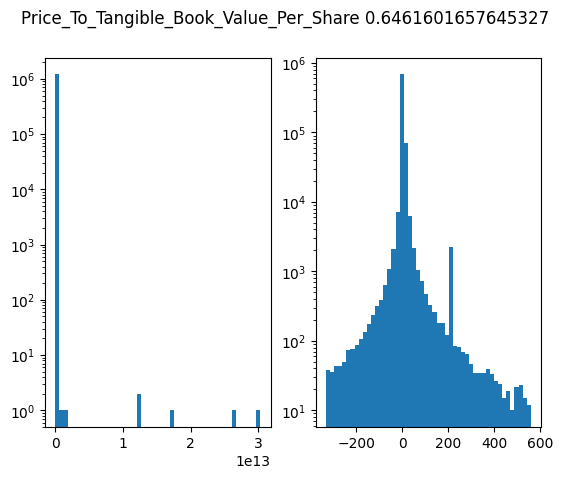

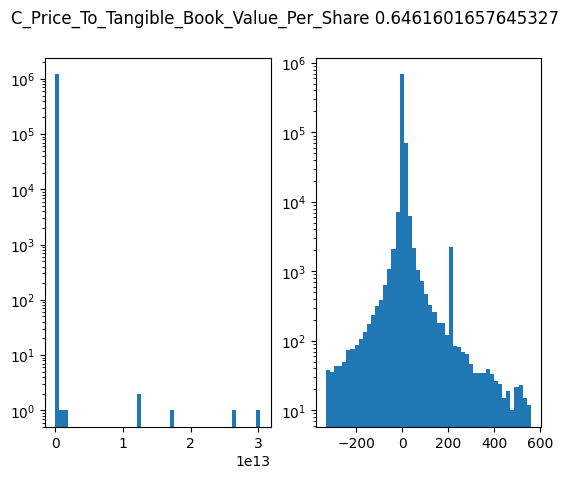

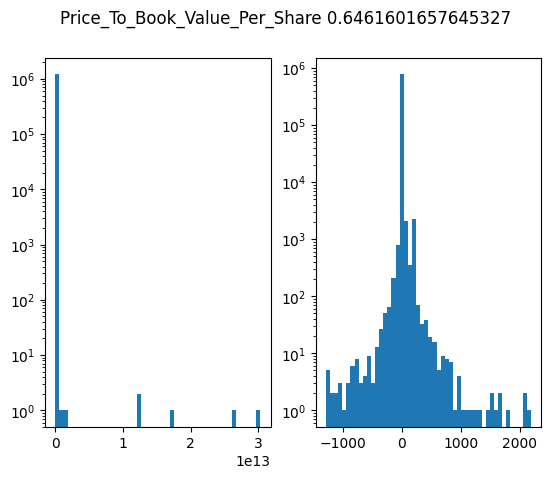

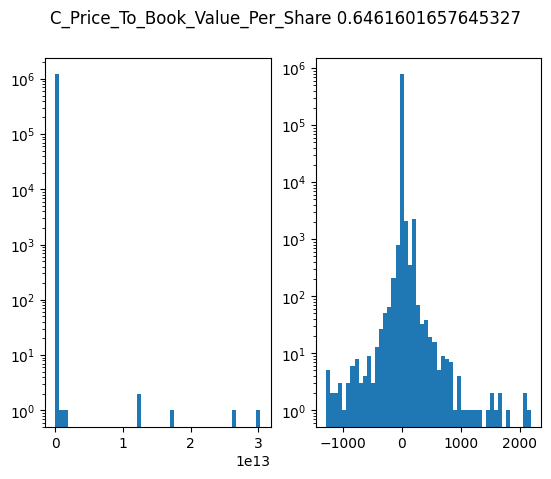

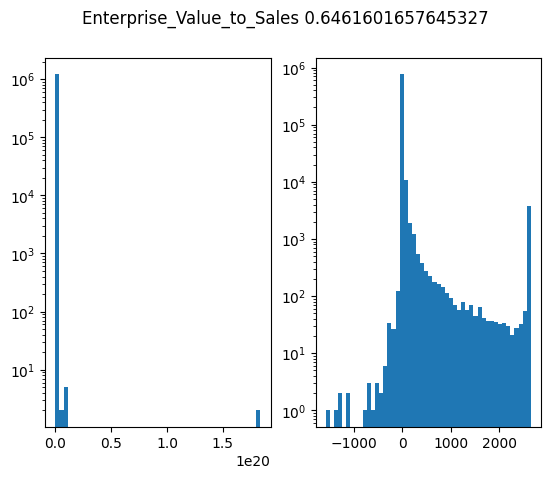

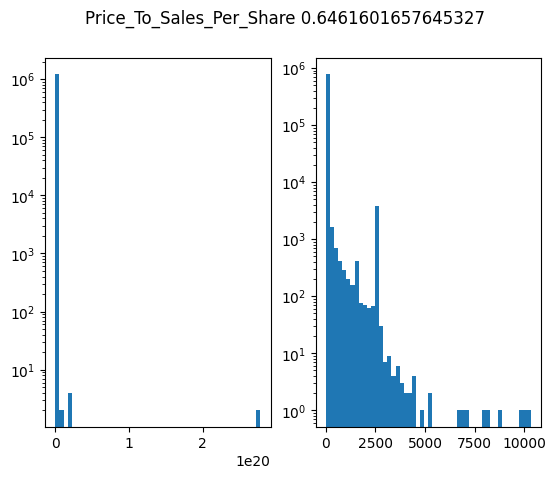

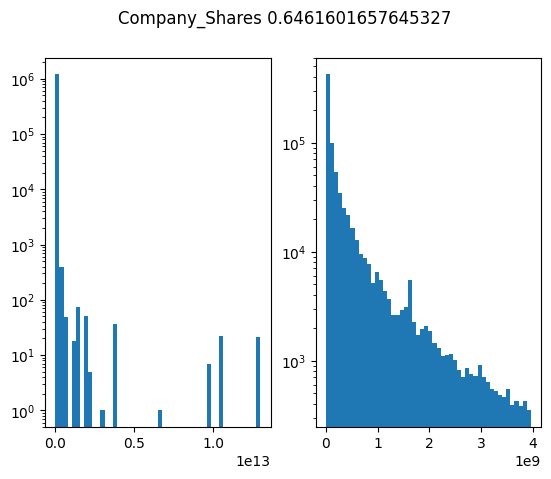

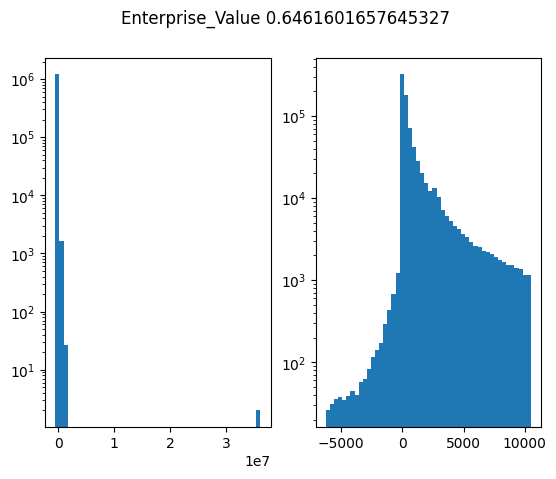

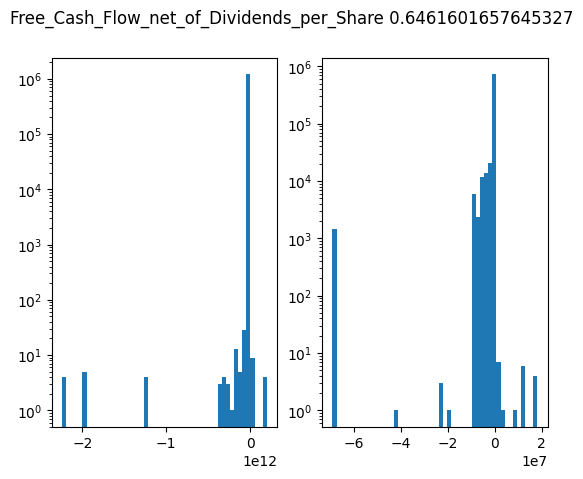

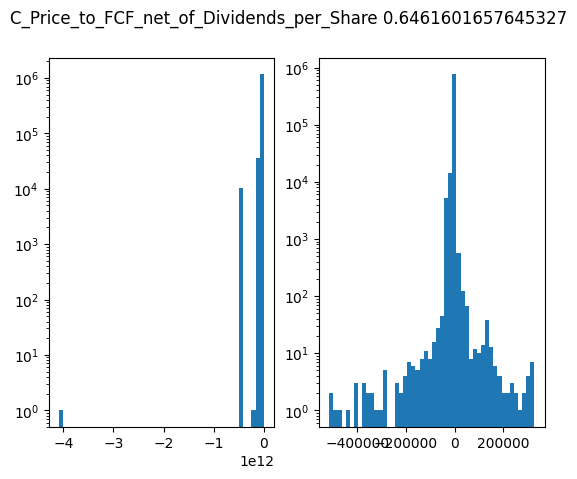

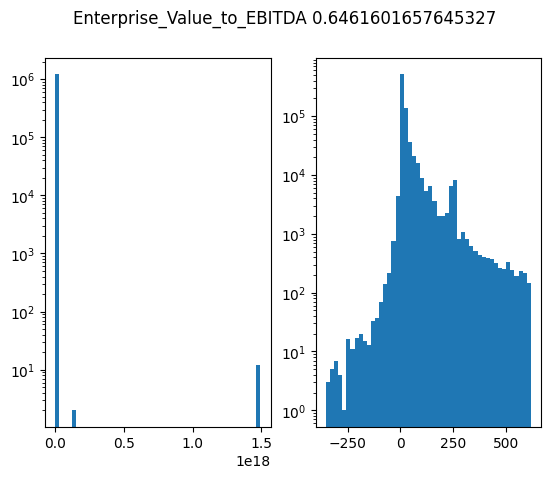

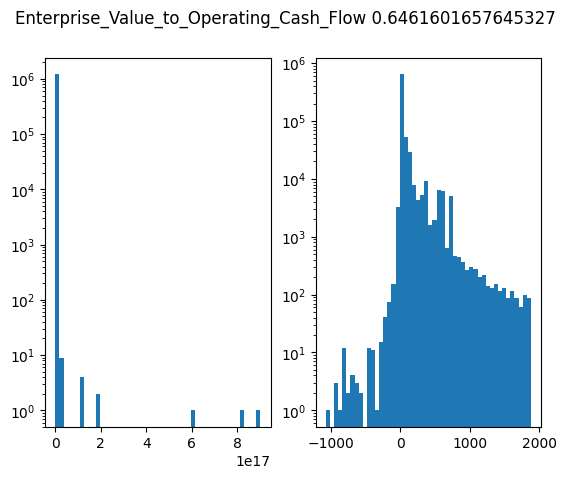

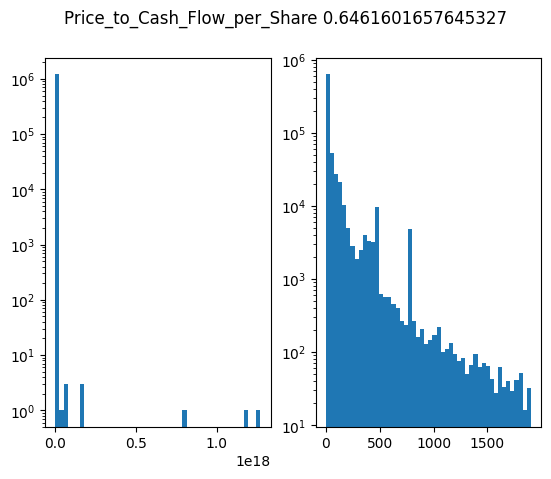

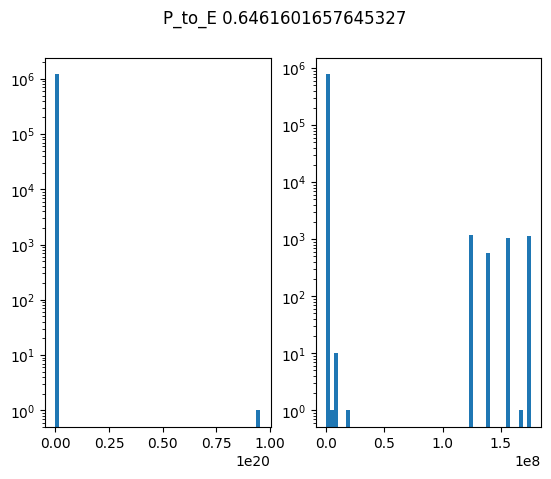

In [68]:
new_data = data[mask]
for fn in reg_columns:
       arr = data[fn].to_numpy()
       f_arr = new_data[fn].to_numpy()
       fig, ax = plt.subplots(1, 2)
       ax[0].hist(arr, bins=50, log=True);
       ax[1].hist(f_arr, bins=50, log=True);
       not_outlier_ratio = f_arr.shape[0]/arr.shape[0]
       plt.suptitle(f'{fn} {not_outlier_ratio}')

In [69]:
new_data.to_csv(join(data_path, 'clear_outliers.csv'), index=False)

In [70]:
test = pd.read_csv(join(data_path, 'clear_test_data.csv'), parse_dates=['Date_round'])
print(test.shape)
test.isna().sum()

(385138, 22)


Price_To_Tangible_Book_Value_Per_Share       0
C_Price_To_Tangible_Book_Value_Per_Share     0
Price_To_Book_Value_Per_Share                0
C_Price_To_Book_Value_Per_Share              0
Enterprise_Value_to_Sales                    0
Price_To_Sales_Per_Share                     0
Company_Shares                               0
Enterprise_Value                             0
Free_Cash_Flow_net_of_Dividends_per_Share    0
C_Price_to_FCF_net_of_Dividends_per_Share    0
Enterprise_Value_to_EBITDA                   0
Enterprise_Value_to_Operating_Cash_Flow      0
Price_to_Cash_Flow_per_Share                 0
P_to_E                                       0
Date_round                                   0
RanksID                                      0
Perf_1Y                                      0
gicsSectorName                               0
gicsIndustryGroupName                        0
gicsIndustryName                             0
gicsSubIndustryName                          0
Country_of_He

In [71]:
mask = get_inliers_mask_target(test)
print(test[mask].shape[0]/test.shape[0])
test = test[mask]

0.900087760750692


In [72]:
sorted(test.Perf_1Y, reverse=True)[:10]

[2.999486437830493,
 2.9994655833380954,
 2.9994535718199207,
 2.999371590396321,
 2.999158814728623,
 2.9987269060762234,
 2.9984743664272724,
 2.9980276060943583,
 2.997657077008056,
 2.99761871795786]

In [73]:
mask = np.ones(test.shape[0], dtype=bool)
for fn in reg_columns:
       arr = data[fn].to_numpy()
       lb, ub = get_inliers_borders(arr, lq, rq)
       mask &= (lb < test[fn]) & (test[fn] < ub)

In [74]:
new_test = test[mask]
new_test.shape[0]/test.shape[0]

0.6248810066405506

In [75]:
new_test.to_csv(join(data_path, 'clear_test_outliers.csv'), index=False)